In [1]:
import re
import STAVAG
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

## Data loading

The data can be download from https://drive.google.com/file/d/1P8Da55JFIT9rDJRy3VP4tKCGL_3RO01g/view?usp=sharing.

In [2]:
adata = sc.read_h5ad(r'E:\Fast_SVG\Data\3D data\cortex_starmap.h5ad')
adata.obs_names_make_unique()
adata.var_names_make_unique()
print(f"Remaining genes: {adata.n_vars}")

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata.obsm['spatial2D'] = adata.obsm['spatial3D'][:,0:2]

Remaining genes: 28


# Visualize The data (2D view)

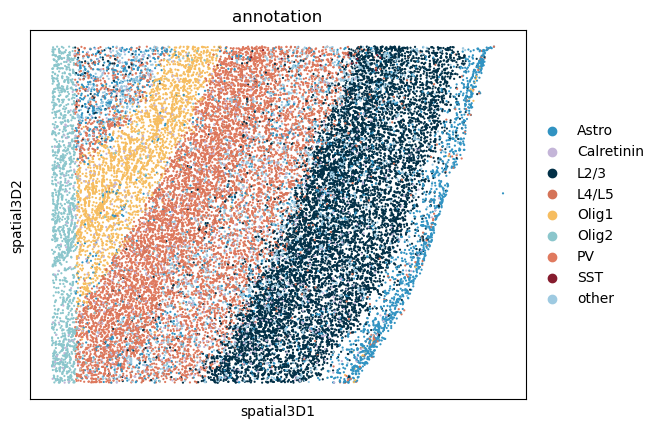

In [3]:
cmap1 = {'Astro': '#3193c2',
 'Calretinin': '#c4b5d8',
 'L2/3': '#023047',
 'L4/L5': '#d57358',
 'Olig1': '#f6bd60',
 'Olig2': '#8bc6cc',
 'PV': '#e07a5f',
 'SST': '#861c2e',
 'other': '#9ecae1'}
sc.pl.embedding(adata, basis='spatial3D', color='annotation', palette=cmap1, s=10)

# Visualize The data (3D view)

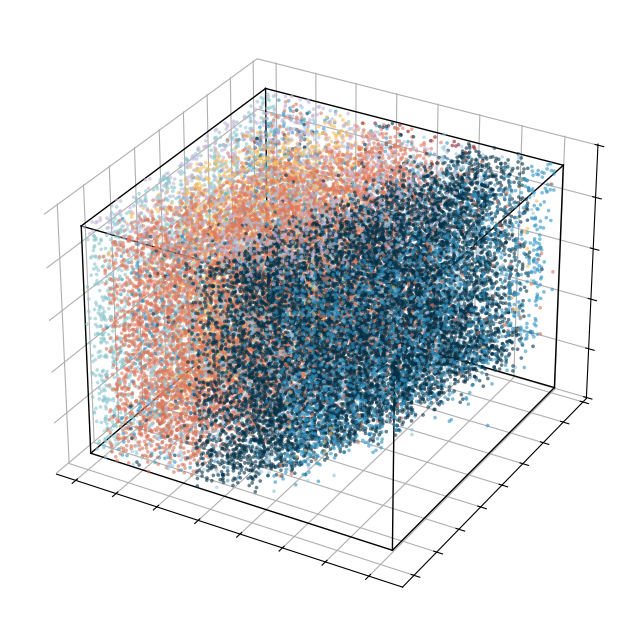

In [4]:
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

random.seed(560)
color_palette = [
    "#f6bd60", "#c4b5d8", "#96b091", "#daa05e", "#a7c0a9", "#84b0b1",
    "#cc9a81", "#9ecae1", "#c7c7c7", "#bfc799", "#ab96b5", "#99c2c2",
    "#e07a5f", "#ebe5c2", "#d57358", "#023047", "#f7ca71", "#1697a6",
    "#8bc6cc", "#c9dec3", "#e9dfd5", "#9ecae1"
]
categories = ['Astro', 'Calretinin', 'L2/3', 'L4/L5', 'Olig1', 'Olig2', 'PV', 'SST', 'other']
color_map = {category: random.choice(color_palette) for category in categories}
color_map['Astro'] = '#3193c2'
color_map['SST'] = '#861c2e'

# Get color list based on each sample's annotation
color_list = [color_map[cat] for cat in adata.obs['annotation']]

# Create figure and 3D axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Get spatial 3D coordinates
coords = adata.obsm['spatial3D']
x_min, x_max = coords[:, 0].min(), coords[:, 0].max()
y_min, y_max = coords[:, 1].min(), coords[:, 1].max()
z_min, z_max = coords[:, 2].min(), coords[:, 2].max()

# Plot data points
scatter = ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], 
                     c=color_list, s=7, alpha=0.6, edgecolors='none', zorder=1)

# Define the 8 corners of the cube
corners = np.array([
    [x_min, y_min, z_min], [x_max, y_min, z_min],
    [x_max, y_max, z_min], [x_min, y_max, z_min],
    [x_min, y_min, z_max], [x_max, y_min, z_max],
    [x_max, y_max, z_max], [x_min, y_max, z_max]
])

# Draw cube edges (black lines)
edges = [
    [0, 1], [1, 2], [2, 3], [3, 0],  # bottom
    [4, 5], [5, 6], [6, 7], [7, 4],  # top
    [0, 4], [1, 5], [2, 6], [3, 7]   # vertical edges
]

for edge in edges:
    ax.plot([corners[edge[0], 0], corners[edge[1], 0]],
            [corners[edge[0], 1], corners[edge[1], 1]],
            [corners[edge[0], 2], corners[edge[1], 2]], color='black', linewidth=1, zorder=2) 

# Hide axis labels but keep tick marks
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zticks([])
ax.set_xticklabels([])  # Remove X-axis tick labels (numbers)
ax.set_yticklabels([])  # Remove Y-axis tick labels (numbers)
ax.set_zticklabels([])  # Remove Z-axis tick labels (numbers)

# Make axis background panes transparent (hide axis boxes but keep tick marks)
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

ax.xaxis.pane.set_facecolor((1, 1, 1, 0))  # Set pane facecolor to transparent
ax.yaxis.pane.set_facecolor((1, 1, 1, 0))
ax.zaxis.pane.set_facecolor((1, 1, 1, 0))

# Disable grid lines (optional)
# ax.grid(False)

# Show plot
plt.show()


## Calculate the corrdinates along radial direction 
## (diagonally downward at a 30° angle)
## store in adata.obs['new_axis']

In [5]:
adata.obs['X_3D'] = adata.obsm['spatial3D'][:,0]
adata.obs['Y_3D'] = adata.obsm['spatial3D'][:,1]
adata.obs['Z_3D'] = adata.obsm['spatial3D'][:,2]
x_min = np.min(adata.obs['X_3D'])
y_max = np.max(adata.obs['Y_3D'])

A = np.sqrt(3)
B = 1
C = -(x_min*np.sqrt(3) + y_max)

x_vals = adata.obs['X_3D'].values
y_vals = adata.obs['Y_3D'].values

distances = np.abs(A*x_vals + B*y_vals + C) / np.sqrt(A**2 + B**2)
adata.obs['new_axis'] = 2*distances+np.sqrt(3)*(y_max-y_vals)

In [6]:
spatial3d = adata.obsm['spatial3D']
new_axis = adata.obs['new_axis'].to_numpy().reshape(-1, 1)
adata.obsm['spatial4D'] = np.hstack([spatial3d, new_axis])

In [7]:
#The columns of coords must be at least 2
#The first column denotes the coordinates on x-axis, the second denotes the coordinates on y-axis
#while the third denotes the coordinates on z-axis, the fourth denotes the coordinates on a-axis (new_aixs)
coords = adata.obsm['spatial4D']
# calculate DVGs along x and y axis
coord_dict = STAVAG.DVG_detection(adata, coords, exact_pvalue=True)
DVG_along_a_axis = list(coord_dict['a']['Feature'])

D:\Tools\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
D:\Tools\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [8]:
coord_dict['a']

,Feature,Importance,sps
6,Cux2,1.713736e+10,0.034483
26,Mbp,1.345386e+10,0.034483
10,Pcp4,1.269126e+10,0.034483
20,Egr1,8.312013e+09,0.034483
4,Rasgrf2,8.204961e+09,0.034483
0,Slc17a7,8.065597e+09,0.034483
12,Npy,6.897210e+09,0.034483
14,Pvalb,6.785712e+09,0.034483
24,Gja1,6.103059e+09,0.034483
16,Calb2,4.976731e+09,0.034483


## # Visualize top-5 DVGs along radial direction (a axis)

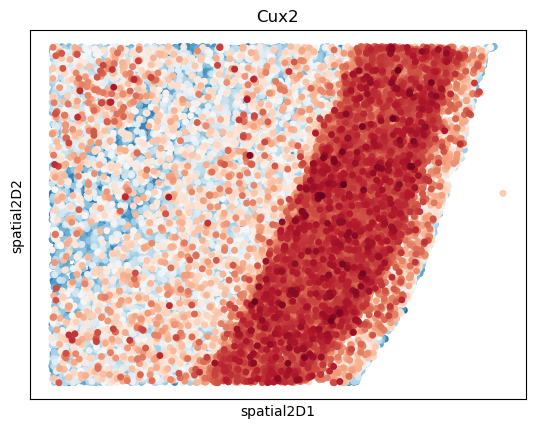

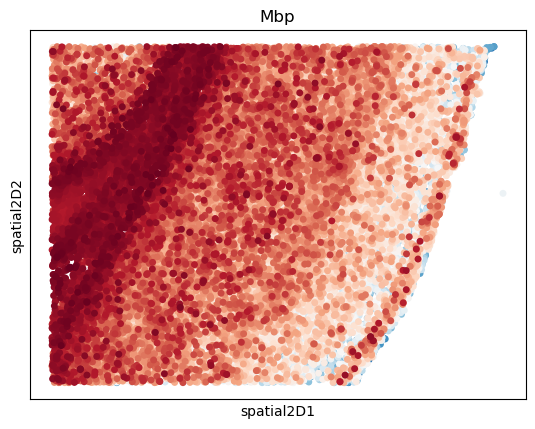

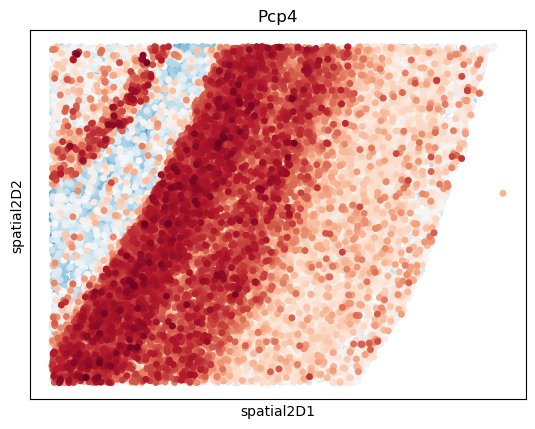

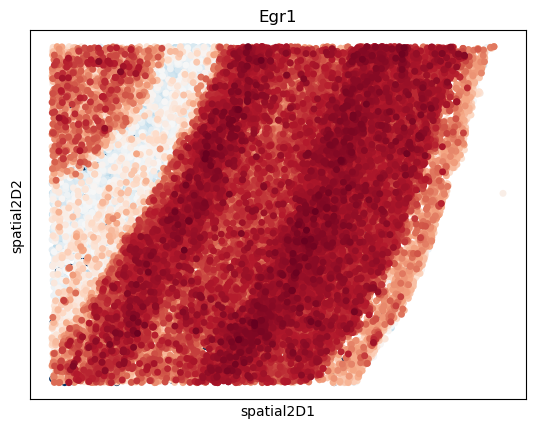

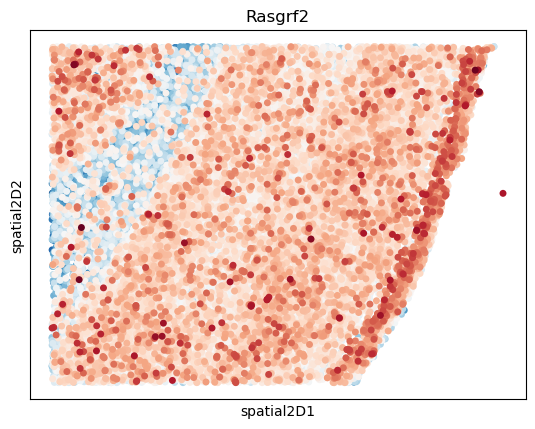

In [10]:
for gene in list(DVG_along_a_axis[0:5]):
    sc.pl.embedding(adata, basis='spatial2D', color=gene, s=100,  cmap='RdBu_r', colorbar_loc=None)

## Gene contribution score versus STAVAG priority scores (sps)

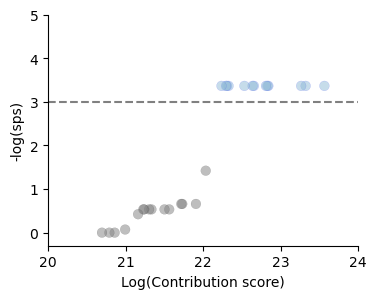

In [13]:
import matplotlib.pyplot as plt

# Define significance threshold (-log(0.05))
threshold = -np.log(0.05)

# Prepare dataframe from coordinates dictionary
pvalue_df = coord_dict['a']

# Create transformed columns
pvalue_df['log_imp'] = np.log(pvalue_df['Importance'])
pvalue_df['-log(sps)'] = -np.log(pvalue_df['sps'])

# Create figure
fig, ax = plt.subplots(figsize=(4, 3))

# Define color scheme based on significance
colors = np.where(pvalue_df['-log(sps)'] < threshold, '#7f7f7f', '#8fbad7')
edge_colors = np.where(pvalue_df['-log(sps)'] < threshold, 'black', 'blue')

# Create scatter plot
scatter = ax.scatter(
    x=pvalue_df['log_imp'], 
    y=pvalue_df['-log(sps)'], 
    alpha=0.5, 
    s=50,
    c=colors,
    edgecolors=edge_colors,
    linewidth=0.1
)

# Add horizontal threshold line
ax.axhline(y=threshold, color='grey', linestyle='--', label='sps = 0.05')

# Format axes
ax.set(xlabel='Log(Contribution score)', 
       ylabel='-log(sps)',
       xlim=(20, 24),  # Set x-axis range based on observed data
       ylim=(-0.3, 5))
ax.set_xticks([20, 21, 22, 23, 24])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()